In [1]:
from copy import deepcopy
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
"""
* Without modifications, with max_cars = 10 due to runtime constraints
"""
credit = 10
move_cost = 2
mean_req_first = 3
mean_req_second = 4
mean_ret_first = 3
mean_ret_second = 2
max_cars = 10
max_moves = 5
discount_factor = 0.9

In [3]:
values = np.zeros((max_cars+1, max_cars+1)) # Since we can have 0 to num_cars
policy = np.zeros((max_cars+1, max_cars+1), dtype=int)
actions = np.arange(-max_moves, max_moves+1)

In [4]:
# Precompute poisson PMFs because it takes a long time otherwise
poisson_pmfs = {}
for i in range(max_cars*3):
    poisson_pmfs[(i, mean_req_first)] = poisson.pmf(i, mean_req_first)
    poisson_pmfs[(i, mean_req_second)] = poisson.pmf(i, mean_req_second)
    poisson_pmfs[(i, mean_ret_first)] = poisson.pmf(i, mean_ret_first)
    poisson_pmfs[(i, mean_ret_second)] = poisson.pmf(i, mean_ret_second)

In [5]:
def get_return(i, j, action, values):
    return_val = 0.0
    
    # Discard the extra cars and account for those that have moved
    remaining_cars_first = min(i - action, max_cars)
    remaining_cars_second = min(j + action, max_cars)
    
    # Cost of moving cars according to the selected action
    return_val -= move_cost * np.abs(action)
    
    # req_1 is the number of loan requirements at location 1
    # req_2 is the number of loan requirements at location 2
    for req_1 in range(max_cars+1):
        for req_2 in range(max_cars+1):
            for ret_1 in range(max_cars+1):
                for ret_2 in range(max_cars+1):
                    num_cars_first = remaining_cars_first
                    num_cars_second = remaining_cars_second
                    
                    rented_out_first = min(num_cars_first, req_1)
                    rented_out_second = min(num_cars_second, req_2)

                    reward = (rented_out_first + rented_out_second) * credit

                    num_cars_first -= rented_out_first
                    num_cars_second -= rented_out_second

                    num_cars_first_ = min(num_cars_first + ret_1, max_cars)
                    num_cars_second_ = min(num_cars_second + ret_2, max_cars)
                    # print (num_cars_first_, num_cars_second_)
                    return_val += (poisson_pmfs[(req_1, mean_req_first)] * \
                                   poisson_pmfs[(req_2, mean_req_second)] * \
                                   poisson_pmfs[(ret_1, mean_ret_first)] * \
                                   poisson_pmfs[(ret_2, mean_ret_second)]) * \
                    (reward + discount_factor * values[num_cars_first_, num_cars_second_])

    return return_val

def evaluate_policy():
    
    theta = 1e-4
    while True:
        delta = 0
        for i in range(max_cars+1):
            for j in range(max_cars+1):
                old_value_s = values[i, j]
                action = policy[i, j]
                values[i, j] = get_return(i, j, action, values)
                delta = max(delta, np.abs(old_value_s - values[i, j]))
        print ("Delta:", delta)
        if delta < theta:
            break
    return values
        
def improve_policy():
    stable = True
    for i in range(max_cars+1):
        for j in range(max_cars+1):
            old_policy = policy[i, j]
            returns = []
            for action in actions:
                if ((0 <= action <= i) or (-j <= action <= 0)):
                    returns.append(get_return(i, j, action, values))
                else:
                    returns.append(-np.inf)
            policy[i, j] = actions[returns.index(max(returns))]
            if policy[i, j] != old_policy:
                print ("Policy Change for State:", (i, j), "New Policy:", policy[i, j], "Old Policy:", old_policy)
                stable = False
    return stable

In [6]:
it = 0
while True:
    it += 1
    values = evaluate_policy()
    stable = improve_policy()
    print ("Iteration", it)
    print ("-----------------------------")
    print ("Values")
    print (values)
    print ("-----------------------------")
    print ("Policy")
    print (policy)
    print ("-----------------------------")
    if stable:
       break 

Delta: 168.92571804672676
Delta: 103.32033602341775
Delta: 65.12881929454386
Delta: 52.08388752216038
Delta: 42.56742660599363
Delta: 35.62883015911794
Delta: 30.10747413895072
Delta: 25.128838400995505
Delta: 20.804558479089337
Delta: 17.137194067394944
Delta: 14.072404460240477
Delta: 11.533878237028034
Delta: 9.442454912708342
Delta: 7.724907030902955
Delta: 6.317119889868593
Delta: 5.164572248501429
Delta: 4.221652764196165
Delta: 3.450563030577598
Delta: 2.8201533798621767
Delta: 2.304838554585558
Delta: 1.8836456153702557
Delta: 1.5394031477551948
Delta: 1.258062429834979
Delta: 1.0281346207053161
Delta: 0.8402268213425259
Delta: 0.6866609492298039
Delta: 0.5611612888955051
Delta: 0.4585986615585398
Delta: 0.3747811111074384
Delta: 0.30628272643281207
Delta: 0.2503036903947873
Delta: 0.20455587803081698
Delta: 0.16716934929667104
Delta: 0.1366159248314034
Delta: 0.11164672613625726
Delta: 0.09124112965639597
Delta: 0.0745650496894541
Delta: 0.06093684540030608
Delta: 0.0497994587

Delta: 0.8451418284049623
Delta: 0.6883979452684912
Delta: 0.5603568492248314
Delta: 0.45597014317507956
Delta: 0.37096032657143496
Delta: 0.30177046872501023
Delta: 0.24547342857647436
Delta: 0.1996738439357273
Delta: 0.16241726339291063
Delta: 0.1321113964147571
Delta: 0.1074600111107884
Delta: 0.08740830757426465
Delta: 0.07109812500829094
Delta: 0.05783135683651608
Delta: 0.047040129888841875
Delta: 0.03826252174894762
Delta: 0.031122798384387806
Delta: 0.025315334789127064
Delta: 0.020591534124719146
Delta: 0.016749186906963587
Delta: 0.013623815452149302
Delta: 0.0110816332783088
Delta: 0.009013818229163917
Delta: 0.00733185415731441
Delta: 0.0059637418804072695
Delta: 0.004850917174792357
Delta: 0.00394574378674406
Delta: 0.00320947429224816
Delta: 0.0026105915207494945
Delta: 0.002123459313963849
Delta: 0.001727225202103
Delta: 0.0014049277325511866
Delta: 0.0011427704690731844
Delta: 0.0009295313220150092
Delta: 0.0007560822589312011
Delta: 0.0006149985184720208
Delta: 0.00050

Policy Change for State: (5, 3) New Policy: 0 Old Policy: 1
Policy Change for State: (6, 2) New Policy: 1 Old Policy: 2
Policy Change for State: (7, 1) New Policy: 2 Old Policy: 3
Policy Change for State: (8, 0) New Policy: 3 Old Policy: 4
Policy Change for State: (8, 7) New Policy: 0 Old Policy: 1
Policy Change for State: (9, 6) New Policy: 1 Old Policy: 2
Policy Change for State: (10, 5) New Policy: 2 Old Policy: 3
Iteration 3
-----------------------------
Values
[[404.22805916 414.1643685  423.97712635 433.52335372 442.66999996
  451.33643035 459.49098227 467.31419319 474.93551062 482.28177932
  489.30963605]
 [414.06201895 423.99824155 433.8105611  443.35564322 452.50019691
  461.16356468 469.31420146 476.93551886 484.28178745 491.30964413
  497.81798466]
 [423.47733146 433.41315071 443.22344683 452.76326581 461.89824928
  470.54772192 478.68084303 486.2817993  493.30965592 499.81799528
  506.12171805]
 [432.20815336 442.14295715 451.94816755 461.47478043 470.58582376
  479.2007627

In [7]:
policy

array([[ 0,  0,  0,  0,  0,  0,  0, -1, -1, -2, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  1,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 3,  2,  2,  2,  1,  1,  0,  0,  0,  0,  0],
       [ 3,  3,  3,  2,  2,  1,  1,  0,  0,  0,  0],
       [ 4,  4,  3,  3,  2,  2,  1,  1,  1,  0,  0],
       [ 5,  4,  4,  3,  3,  2,  2,  2,  1,  1,  0]])

In [8]:
values

array([[404.28307621, 414.21938412, 424.03211329, 433.57819323,
        442.72442517, 451.39006508, 459.54346844, 467.3668154 ,
        474.98673164, 482.33344958, 489.35974895],
       [414.1172341 , 424.05345534, 433.86574553, 443.41067615,
        452.55480437, 461.21736192, 469.36682429, 476.9867405 ,
        484.33345831, 491.35975764, 497.86887163],
       [423.53336908, 433.46918665, 443.27944877, 452.81909596,
        461.95360409, 470.60218311, 478.73402453, 486.33347105,
        493.3597703 , 499.86888305, 506.17097707],
       [432.26595123, 442.20075135, 452.00591246, 461.53229993,
        470.64275112, 479.25661599, 487.34526451, 494.89560872,
        501.86889568, 508.17098964, 513.64942455],
       [440.21550869, 450.14843637, 459.94421391, 469.44622527,
        478.51252565, 487.06295736, 495.07343755, 502.53650166,
        509.41812441, 515.62810361, 521.01837855],
       [448.14844775, 457.94422343, 467.4462344 , 476.60450945,
        485.60408343, 494.05874087, 501.9

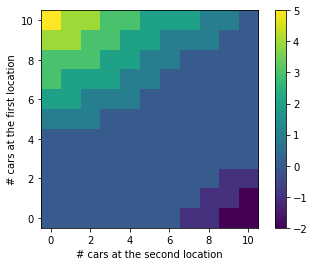

In [9]:
plt.imshow(policy, origin='lower')
plt.colorbar()
plt.xlabel("# cars at the second location")
plt.ylabel("# cars at the first location")
plt.show()

In [10]:
"""
* With modifications, with max_cars = 10 due to runtime constraints
"""

credit = 10
move_cost = 2
mean_req_first = 3
mean_req_second = 4
mean_ret_first = 3
mean_ret_second = 2
max_cars = 10
max_moves = 5
discount_factor = 0.9
free_shuttles = 1
parking_limit = 5 # set to a value less than the max cars per location
parking_cost = 4

In [11]:
values = np.zeros((max_cars+1, max_cars+1)) # Since we can have 0 to num_cars
policy = np.zeros((max_cars+1, max_cars+1), dtype=int)
actions = np.arange(-max_moves, max_moves+1)

In [12]:
# Precompute poisson PMFs because it takes a long time otherwise
poisson_pmfs = {}
for i in range(max_cars*3):
    poisson_pmfs[(i, mean_req_first)] = poisson.pmf(i, mean_req_first)
    poisson_pmfs[(i, mean_req_second)] = poisson.pmf(i, mean_req_second)
    poisson_pmfs[(i, mean_ret_first)] = poisson.pmf(i, mean_ret_first)
    poisson_pmfs[(i, mean_ret_second)] = poisson.pmf(i, mean_ret_second)     

In [13]:
def get_return(i, j, action, values):
    return_val = 0.0
    
    # Check for free shuttles and reduce reward due to moving cars
    if action > 0:
        return_val -= move_cost * (np.abs(action) - free_shuttles)
    else:
        return_val -= move_cost * np.abs(action)
    
    # Discard the extra cars and account for those that have moved overnight
    remaining_cars_first = min(i - action, max_cars)
    remaining_cars_second = min(j + action, max_cars)
    
    # Check overnight parking deductions after moving of cars
    parking_deduction = 0
    if remaining_cars_first > parking_limit:
        return_val -= parking_cost
    if remaining_cars_second > parking_limit:
        return_val -= parking_cost
    
    # req_1 is the number of loan requirements at location 1
    # req_2 is the number of loan requirements at location 2
    for req_1 in range(max_cars+1):
        for req_2 in range(max_cars+1):
            for ret_1 in range(max_cars+1):
                for ret_2 in range(max_cars+1):
                    num_cars_first = remaining_cars_first
                    num_cars_second = remaining_cars_second
                    
                    rented_out_first = min(num_cars_first, req_1)
                    rented_out_second = min(num_cars_second, req_2)

                    reward = (rented_out_first + rented_out_second) * credit

                    num_cars_first -= rented_out_first
                    num_cars_second -= rented_out_second

                    num_cars_first_ = min(num_cars_first + ret_1, max_cars)
                    num_cars_second_ = min(num_cars_second + ret_2, max_cars)
                    # print (num_cars_first_, num_cars_second_)
                    return_val += (poisson_pmfs[(req_1, mean_req_first)] * \
                                   poisson_pmfs[(req_2, mean_req_second)] * \
                                   poisson_pmfs[(ret_1, mean_ret_first)] * \
                                   poisson_pmfs[(ret_2, mean_ret_second)]) * \
                    (reward + discount_factor * values[num_cars_first_, num_cars_second_])

    return return_val

def evaluate_policy():
    
    theta = 1e-4
    while True:
        delta = 0
        for i in range(max_cars+1):
            for j in range(max_cars+1):
                old_value_s = values[i, j]
                action = policy[i, j]
                values[i, j] = get_return(i, j, action, values)
                delta = max(delta, np.abs(old_value_s - values[i, j]))
        print ("Delta:", delta)
        if delta < theta:
            break
    return values
        
def improve_policy():
    stable = True
    for i in range(max_cars+1):
        for j in range(max_cars+1):
            old_policy = policy[i, j]
            returns = []
            for action in actions:
                if ((0 <= action <= i) or (-j <= action <= 0)):
                    returns.append(get_return(i, j, action, values))
                else:
                    returns.append(-np.inf)
            policy[i, j] = actions[returns.index(max(returns))]
            if policy[i, j] != old_policy:
                print ("Policy Change for State:", (i, j), "New Policy:", policy[i, j], "Old Policy:", old_policy)
                stable = False
    return stable

In [14]:
it = 0
while True:
    it += 1
    values = evaluate_policy()
    stable = improve_policy()
    print ("Iteration", it)
    print ("-----------------------------")
    print ("Values")
    print (values)
    print ("-----------------------------")
    print ("Policy")
    print (policy)
    print ("-----------------------------")
    if stable:
       break 

Delta: 151.99442026688664
Delta: 94.44659719584384
Delta: 61.379502518968124
Delta: 49.50471532820262
Delta: 40.33366491667681
Delta: 33.75914204429455
Delta: 28.437893506051807
Delta: 23.691646945846003
Delta: 19.593305212976134
Delta: 16.12895084290892
Delta: 13.239294644716097
Delta: 10.848494544341747
Delta: 8.88008493059948
Delta: 7.264203121643675
Delta: 5.94006400303806
Delta: 4.85615556752947
Delta: 3.9694687733439764
Delta: 3.2444028771201943
Delta: 2.651639421191419
Delta: 2.1671071354927562
Delta: 1.7710790209337688
Delta: 1.4474061806257055
Delta: 1.1828776566129022
Delta: 0.9666903114177217
Delta: 0.7900121481813471
Delta: 0.6456237308202617
Delta: 0.5276242928053421
Delta: 0.43119113906544726
Delta: 0.3523828131021105
Delta: 0.2879781355085811
Delta: 0.23534460998718032
Delta: 0.19233085514343884
Delta: 0.157178683911809
Delta: 0.1284512458260565
Delta: 0.10497429964999583
Delta: 0.08578821791462587
Delta: 0.07010876290354418
Delta: 0.05729503113246892
Delta: 0.0468232564

Delta: 42.38980095012454
Delta: 9.26202382069647
Delta: 5.305728608142999
Delta: 4.358791028627138
Delta: 3.669851504620226
Delta: 3.026192694867291
Delta: 2.470711173817847
Delta: 2.011940160096458
Delta: 1.6369123244086836
Delta: 1.3312613757581744
Delta: 1.0824668260497106
Delta: 0.8800792882836959
Delta: 0.7154951989023175
Delta: 0.5816750242121316
Delta: 0.4728772861781749
Delta: 0.3844267889203934
Delta: 0.3125197013574166
Delta: 0.25406242294860704
Delta: 0.2065394932875506
Delta: 0.16790576041711347
Delta: 0.13649853575026327
Delta: 0.11096610518046646
Delta: 0.09020958188619943
Delta: 0.07333562289881002
Delta: 0.05961798513953909
Delta: 0.048466270381879895
Delta: 0.03940051565143676
Delta: 0.03203053625952634
Delta: 0.026039132615892413
Delta: 0.02116843819180758
Delta: 0.01720882112641675
Delta: 0.013989861785660196
Delta: 0.01137301801634294
Delta: 0.009245662380351405
Delta: 0.00751623472058327
Delta: 0.006110301454441469
Delta: 0.004967352044843665
Delta: 0.0040381946042

Delta: 0.0001294257419317546
Delta: 0.00010519049817503401
Delta: 8.549335422003423e-05
Policy Change for State: (5, 0) New Policy: 1 Old Policy: 2
Policy Change for State: (6, 10) New Policy: 0 Old Policy: 1
Policy Change for State: (7, 9) New Policy: 0 Old Policy: 1
Policy Change for State: (8, 5) New Policy: 0 Old Policy: 3
Policy Change for State: (10, 6) New Policy: 1 Old Policy: 2
Iteration 3
-----------------------------
Values
[[407.05579206 416.98175235 426.73755232 436.11664828 444.91114791
  452.97566276 460.79223584 468.12428037 474.63201565 480.13262399
  484.60206247]
 [416.98175564 426.82172686 436.57621083 445.95163049 454.73891834
  462.79224414 470.12428861 476.63202243 482.1326286  486.60206511
  491.39239921]
 [426.82173622 436.5762195  446.00116147 455.36088888 464.11769023
  472.12430058 478.63203329 484.13263696 488.60207053 493.39240988
  498.2361549 ]
 [436.25235099 446.00117246 455.36089998 464.11770214 472.73004677
  480.63204522 486.13264749 490.60207857 495

In [15]:
policy

array([[ 0,  0,  0,  0,  0,  0, -1, -2, -3, -4, -5],
       [ 1,  0,  0,  0,  0,  0, -1, -2, -3, -4, -2],
       [ 1,  1,  0,  0,  0,  0, -1, -2, -3, -1, -2],
       [ 1,  1,  1,  1,  0,  0, -1, -2,  0, -1, -1],
       [ 1,  1,  1,  1,  1,  0, -1,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  0],
       [ 3,  2,  2,  2,  1,  2,  2,  2,  2,  0,  0],
       [ 3,  3,  3,  2,  1,  0,  3,  1,  1,  1,  0],
       [ 4,  4,  3,  2,  1,  0,  1,  1,  1,  1,  0],
       [ 5,  4,  3,  2,  1,  0,  1,  1,  1,  1,  0]])

In [16]:
values

array([[407.09030637, 417.01625263, 426.77202133, 436.15113751,
        444.94585226, 453.01091039, 460.82763546, 468.16036844,
        474.66981664, 480.17357652, 484.64781889],
       [417.01625638, 426.8563544 , 436.61080688, 445.9862489 ,
        454.77376018, 462.82764492, 470.16037784, 476.66982437,
        482.17358179, 486.6478219 , 491.43471205],
       [426.85636507, 436.61081676, 446.03629674, 455.39606379,
        464.15313818, 472.16039149, 478.66983674, 484.17359131,
        488.64782808, 493.43472423, 498.28282636],
       [436.28751774, 446.03630927, 455.39607645, 464.15315176,
        472.76695083, 480.66985035, 486.17360332, 490.64783724,
        495.43473773, 500.28283821, 504.80006894],
       [445.01986737, 454.75547844, 464.07911639, 472.76696268,
        480.66986256, 488.17361532, 492.64784813, 497.04083409,
        502.28285014, 506.80008081, 510.58921782],
       [452.89032247, 462.60343831, 471.86630069, 480.43972331,
        488.17362577, 494.64785897, 497.2

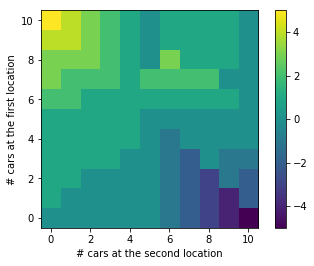

In [17]:
plt.imshow(policy, origin='lower')
plt.colorbar()
plt.xlabel("# cars at the second location")
plt.ylabel("# cars at the first location")
plt.show()